In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Model parameters
mu = 0.05        # drift
sigma = 0.2      # volatility
T = 1.0          # time horizon
N = 252          # number of time steps
dt = T / N

# Simulation parameters
num_paths = 500
x0 = 1.0         # initial value


In [3]:
def simulate_gbm_paths(mu, sigma, x0, T, N, num_paths, seed=42):
    np.random.seed(seed)
    dt = T / N

    paths = np.zeros((num_paths, N + 1))
    paths[:, 0] = x0

    for t in range(1, N + 1):
        z = np.random.randn(num_paths)
        paths[:, t] = paths[:, t - 1] * np.exp(
            (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z
        )

    return paths


In [4]:
paths = simulate_gbm_paths(
    mu=mu,
    sigma=sigma,
    x0=x0,
    T=T,
    N=N,
    num_paths=num_paths
)

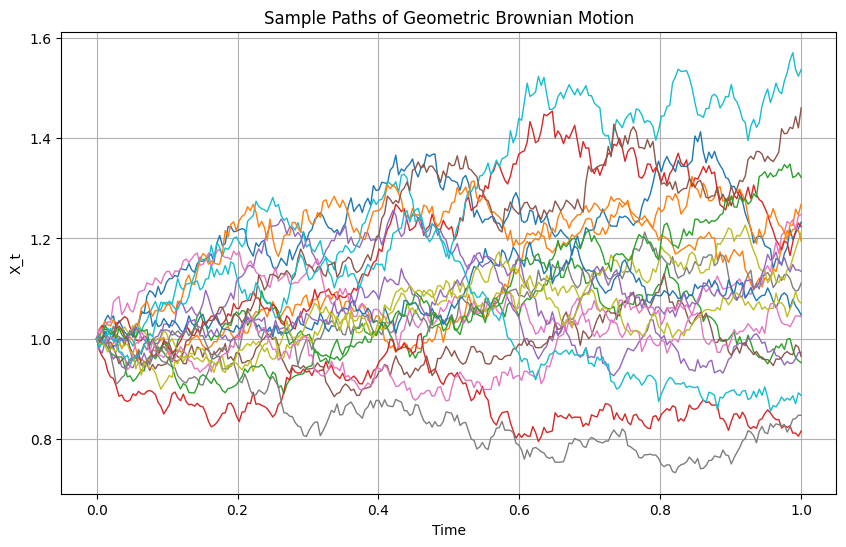

In [5]:
time_grid = np.linspace(0, T, N + 1)

plt.figure(figsize=(10, 6))
for i in range(20):
    plt.plot(time_grid, paths[i], lw=1)

plt.xlabel("Time")
plt.ylabel("X_t")
plt.title("Sample Paths of Geometric Brownian Motion")
plt.grid(True)
plt.show()


In [6]:
def payoff(x, K):
    return np.maximum(x - K, 0.0)


In [7]:
K = 1.0  # payoff threshold


In [8]:
def optimal_stopping_mc(paths, K):
    """
    Backward induction Monte Carlo algorithm
    for an optimal stopping problem.

    paths: array of shape (num_paths, N+1)
    """
    num_paths, num_steps = paths.shape
    N = num_steps - 1

    # Initialize value function
    values = payoff(paths[:, -1], K)

    # Store stopping times
    stopping_times = np.full(num_paths, N)

    # Backward induction
    for t in range(N - 1, -1, -1):
        immediate = payoff(paths[:, t], K)

        # Continuation value: conditional expectation via sample mean
        continuation = values

        stop = immediate >= continuation

        values = np.where(stop, immediate, continuation)
        stopping_times = np.where(stop, t, stopping_times)

    return values, stopping_times


In [9]:
values, stopping_times = optimal_stopping_mc(paths, K)


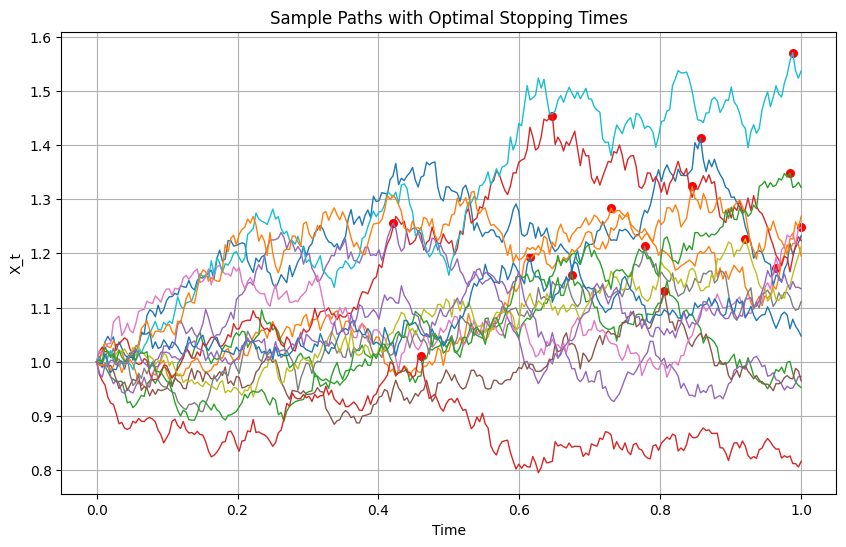

In [10]:
plt.figure(figsize=(10, 6))

# Plot a few paths
for i in range(15):
    t_stop = stopping_times[i]
    plt.plot(time_grid, paths[i], lw=1)
    plt.scatter(time_grid[t_stop], paths[i, t_stop], color="red", s=30)

plt.xlabel("Time")
plt.ylabel("X_t")
plt.title("Sample Paths with Optimal Stopping Times")
plt.grid(True)
plt.show()


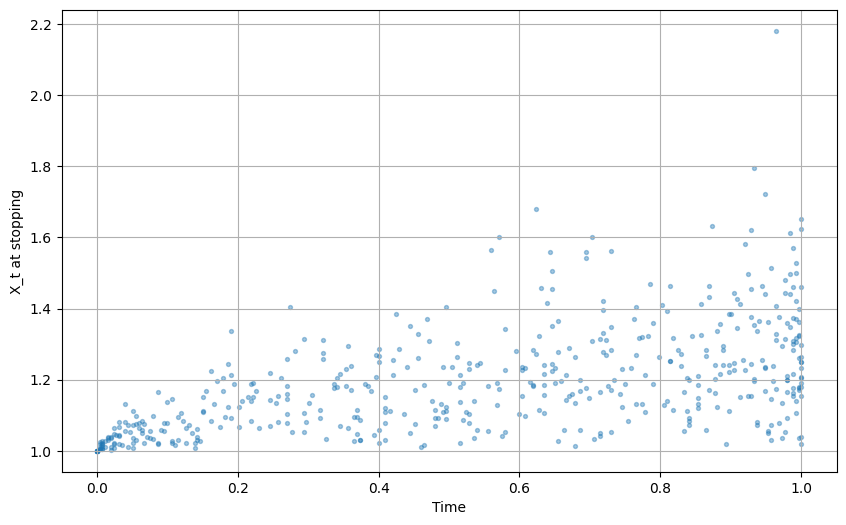

In [11]:
# Extract stopping points
t_stops = stopping_times
x_stops = paths[np.arange(num_paths), stopping_times]

# Convert stopping indices to time
t_vals = time_grid[t_stops]

plt.figure(figsize=(10, 6))
plt.scatter(t_vals, x_stops, s=8, alpha=0.4)

plt.xlabel("Time")
plt.ylabel("X_t at stopping")
plt.grid(True)
plt.show()


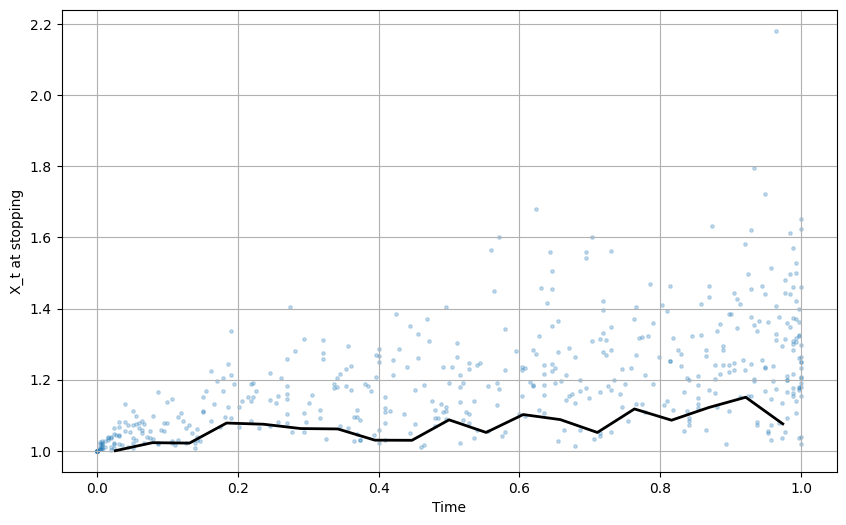

In [12]:
# Approximate stopping boundary via binning
bins = np.linspace(0, T, 20)
boundary = []

for i in range(len(bins) - 1):
    mask = (t_vals >= bins[i]) & (t_vals < bins[i + 1])
    if np.any(mask):
        boundary.append((0.5 * (bins[i] + bins[i + 1]), np.percentile(x_stops[mask], 10)))

boundary = np.array(boundary)

plt.figure(figsize=(10, 6))
plt.scatter(t_vals, x_stops, s=6, alpha=0.25)
plt.plot(boundary[:, 0], boundary[:, 1], color="black", lw=2)

plt.xlabel("Time")
plt.ylabel("X_t at stopping")
plt.grid(True)
plt.show()


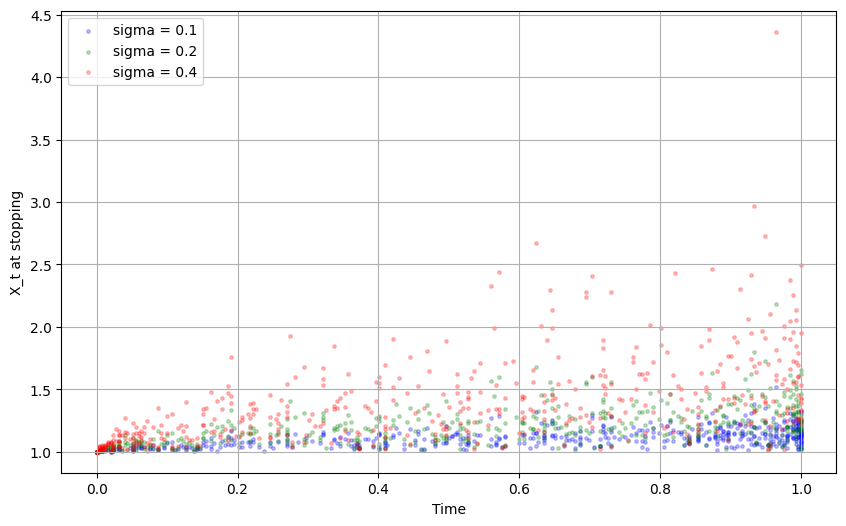

In [13]:
sigmas = [0.1, 0.2, 0.4]
colors = ["blue", "green", "red"]

plt.figure(figsize=(10, 6))

for sigma_val, color in zip(sigmas, colors):
    paths_sigma = simulate_gbm_paths(
        mu=mu,
        sigma=sigma_val,
        x0=x0,
        T=T,
        N=N,
        num_paths=num_paths
    )

    _, stopping_times_sigma = optimal_stopping_mc(paths_sigma, K)

    t_stops = stopping_times_sigma
    x_stops = paths_sigma[np.arange(num_paths), stopping_times_sigma]
    t_vals = time_grid[t_stops]

    plt.scatter(
        t_vals,
        x_stops,
        s=6,
        alpha=0.25,
        label=f"sigma = {sigma_val}",
        color=color
    )

plt.xlabel("Time")
plt.ylabel("X_t at stopping")
plt.legend()
plt.grid(True)
plt.show()
